<a href="https://colab.research.google.com/github/daluri98/Tpot-analysis/blob/main/predict_charges.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import dataset file (insurance.csv) from drive and read it as a dataframe

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

# Define the file path
file_path = '/content/drive/MyDrive/insurance.csv'

# Read the CSV file
df = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Preprocessing Data: Remove missing values, perform encoding techniques for relevant non-numeric data.

In [ ]:
missing_values = df.isnull().sum() #find missing values
missing_values

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [ ]:
label_encoder = LabelEncoder()
df['sex'] = label_encoder.fit_transform(df['sex'])
df['smoker'] = label_encoder.fit_transform(df['smoker'])

# One-hot encode the 'region' column
df = pd.get_dummies(df, columns=['region'])

# Split train data and test data
X = df.drop('charges', axis=1)
y = df['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
!pip install tpot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.4/87.4 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11939 sha256=55b9486992c3cea772f927393b3e626808f5566434319e0627a17225bdf65066
  Stored in directory: /root/.cache/pip/wheels/af/f9/87/bf5b3d565c2a007b4dae9d8142dccc85a9f164e517062dd519
Successfully built stopit


Select the machine learning model to predict charges. To find the best mode, the code uses TPOTRegressor.

In [ ]:
from tpot import TPOTRegressor
tpot = TPOTRegressor(
    generations=5,  # Number of generations to run
    population_size=20,  # Population size in each generation
    verbosity=2,  # Set verbosity level to see progress
    random_state=42,  # Set random seed for reproducibility
    scoring='neg_mean_squared_error',  # Specify the evaluation metric
    config_dict='TPOT sparse',  # Use a configuration with sparse features
    n_jobs=-1  # Utilize all available CPU cores
)

tpot.fit(X_train, y_train)

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -21444197.990079533

Generation 2 - Current best internal CV score: -21444197.990079533

Generation 3 - Current best internal CV score: -21402430.438520286

Generation 4 - Current best internal CV score: -21402430.438520286

Generation 5 - Current best internal CV score: -21262892.98355825

Best pipeline: RandomForestRegressor(input_matrix, bootstrap=True, max_features=0.9500000000000001, min_samples_leaf=16, min_samples_split=8, n_estimators=100)


TPOTRegressor(config_dict='TPOT sparse', generations=5, n_jobs=-1,
              population_size=20, random_state=42,
              scoring='neg_mean_squared_error', verbosity=2)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Get the best pipeline (model)
best_model = tpot.fitted_pipeline_

In [ ]:
# Make predictions using the best model
best_model_pred = best_model.predict(X_test)

We find the factors affecting insurance charges for easy data analysis in the next steps.

In [ ]:
random_forest = best_model.named_steps['randomforestregressor']

In [ ]:
feature_importances = random_forest.feature_importances_

In [ ]:
# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

In [ ]:
# Sort the DataFrame by importance values in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)


In [ ]:
importance_df

,Feature,Importance
4,smoker,0.696352
2,bmi,0.173225
0,age,0.118512
3,children,0.007154
5,region_northeast,0.001801
1,sex,0.001314
7,region_southeast,0.000716
8,region_southwest,0.000537
6,region_northwest,0.000389


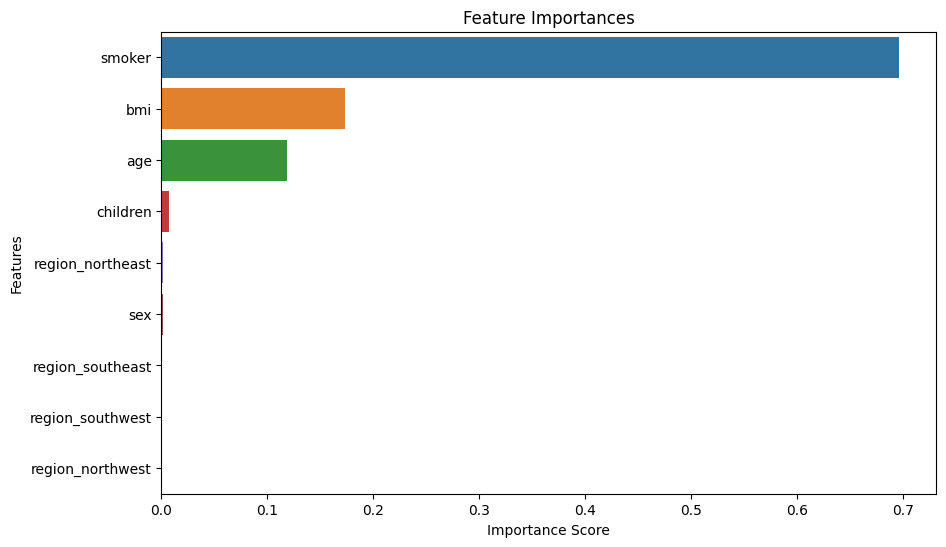

In [ ]:
# Visualize feature importances
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

Evaluation metrics to assess model performance.

In [ ]:
# Evaluate the best model
mae_best_model = mean_absolute_error(y_test, best_model_pred)
mse_best_model = mean_squared_error(y_test, best_model_pred)
r2_best_model = r2_score(y_test, best_model_pred)

print("MAE:", mae_best_model)
print("MSE:", mse_best_model)
print("R-squared:", r2_best_model)

import joblib

joblib.dump(best_model, 'best_model.pkl') #Save the best model using joblib to load and reuse.



MAE: 2502.9320565198227
MSE: 19170289.393855605
R-squared: 0.8765188661469261


['best_model.pkl']

Predicted charges on original dataset

In [ ]:
original_df = df
X_original = original_df.drop('charges', axis=1)

In [ ]:
predictions_original = best_model.predict(X_original)

In [ ]:
original_df['predicted_charges'] = predictions_original

In [ ]:
def map_region(row):
    if row['region_northeast'] == 1:
        return 'northeast'
    elif row['region_northwest'] == 1:
        return 'northwest'
    elif row['region_southeast'] == 1:
        return 'southeast'
    elif row['region_southwest'] == 1:
        return 'southwest'
    else:
        return 'unknown'

In [ ]:
original_df['region_name'] = df.apply(map_region, axis=1)

# Drop the numerical region columns if needed
original_df = original_df.drop(['region_northeast', 'region_northwest', 'region_southeast', 'region_southwest'], axis=1)



Save the dataframe with predicted charges and a single region column along with other columns as a CSV file to use a data source for Data Analysis in Google Data Studio

In [ ]:
original_df.to_csv('combined.csv', index = False)

Visualizing results using matplotlib and seaborn

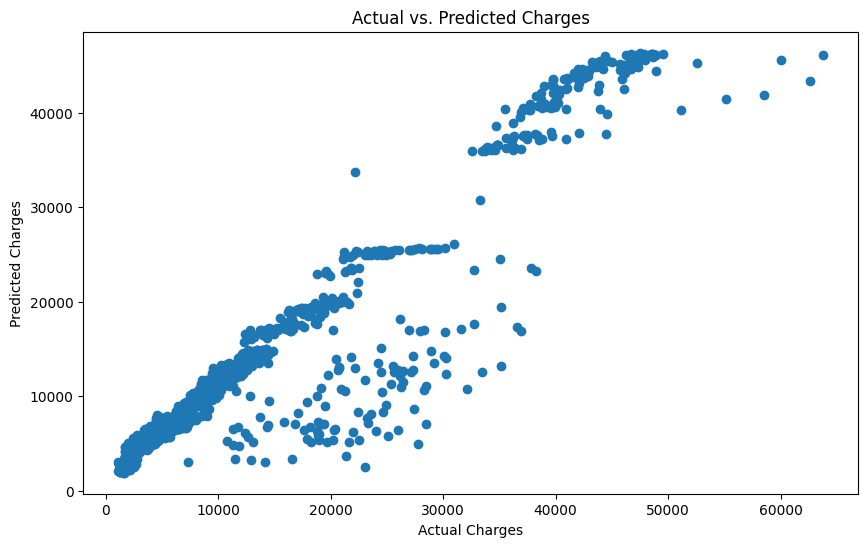

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example 1: Scatter plot of actual vs. predicted charges
plt.figure(figsize=(10, 6))
plt.scatter(original_df['charges'], original_df['predicted_charges'])
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Actual vs. Predicted Charges')
plt.show()



Predicting on Custom Dataset

In [ ]:
import pandas as pd

# Define the data as a dictionary
data = {
    'age': [45],
    'sex': [0],  # 0 for female, 1 for male
    'bmi': [29.900],
    'children': [0],
    'smoker': [1],  # 0 for non-smoker, 1 for smoker
    'region_northeast': [0],
    'region_northwest': [1],
    'region_southeast': [0],
    'region_southwest': [0]
}

# Create the DataFrame
data = pd.DataFrame(data)

# Display the DataFrame
print(data)

   age  sex   bmi  children  smoker  region_northeast  region_northwest  \
0   45    0  29.9         0       1                 0                 1   

   region_southeast  region_southwest  
0                 0                 0  


In [ ]:
predict_new = best_model.predict(data)

In [ ]:
data['predicted_charges'] = predict_new

In [ ]:
data

,age,sex,bmi,children,smoker,region_northeast,region_northwest,region_southeast,region_southwest,predicted_charges
0,45,0,29.9,0,1,0,1,0,0,25178.633408
